In [1]:
import sys, os, glob, warnings, logging
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sw_plotting import change_bar_width
from sw_utilities import tukeyTest

# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

# ignore warnings
warnings.filterwarnings('ignore')

# plotting configuration
font = {'family' : 'Arial',
        'size'   : 7}
matplotlib.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'

# Make a folder if it is not already there to store exported figures
!mkdir ../jupyter_figures


mkdir: ../jupyter_figures: File exists


In [45]:
def get_linescan_data(folder, sgRNA, time_d, n_edges=5):
    '''
    Read in linescan data and annotate with meta data
    
    Inputs:
    -------
        - folder: the folder that contains the linescan output csv file
        - sgRNA: which sgRNA was used for the treatment of this group
        - time_d: how many days after culture the samples were collected
        - n_edges: how many edges were quantified per sample
        
    Outputs:
        - df: pandas data frame with linescan data and annotation data
        
    '''
    
    linescan_files = glob.glob(os.path.join(folder, '*.txt'))

    if len(linescan_files) > 1:
        print('There are more than 1 output file in', folder)
        print('The newest one will be used.')
        linescan_files = sorted(linescan_files,
                                key = os.path.getmtime)
        
    df = pd.read_csv(linescan_files[-1])
    
    # annotate data
    assert len(df) % 5 == 0
    n_organoids = int(len(df) / 5)
    
    sample_ids = []
    for i in range(n_organoids):
        for j in range(n_edges):
            sample_ids.append(sgRNA + '_' + str(i+1))
    
    df['sample_id'] = sample_ids
    df['sgRNA'] = [sgRNA]*len(df)
    df['time_d'] = time_d
    df['groups'] = [sgRNA + '_' + str(time_d)]*len(df)
    
    return df

In [46]:
input_folder = '../data/220608-b1int-IF-time-course'
folders = glob.glob(os.path.join(input_folder, '*line-scan-output' + os.path.sep))

In [47]:
dfs = []
for folder in folders:
    if folder.endswith(os.path.sep):
        folder = folder[:-1]
    sgRNA = os.path.basename(folder).split('-')[1]
    time_d = int(os.path.basename(folder).split('-')[4][0])
    dfs.append(get_linescan_data(folder, sgRNA, time_d, n_edges=5))

In [48]:
df = pd.concat(dfs)
df.reset_index(drop=True, inplace=True)

In [49]:
df.tail()

,file_name,edge_category,id,b1int_AUC,b1int_peak_height,NLSmSL_cell_1,NLSmSL_cell_2,z_position,sample_id,sgRNA,time_d,groups
420,6,High_High,1,2084.8348,232.6014,6.6626,5.9507,1,no_virus_6,no_virus,0,no_virus_0
421,6,High_High,2,6719.4988,606.4597,5.4863,5.9859,1,no_virus_6,no_virus,0,no_virus_0
422,6,High_High,3,3955.5658,538.2629,6.5926,5.9035,1,no_virus_6,no_virus,0,no_virus_0
423,6,High_High,4,192.4889,85.2923,5.5230,5.4700,1,no_virus_6,no_virus,0,no_virus_0
424,6,High_High,5,1170.4729,89.8526,4.8460,5.8239,1,no_virus_6,no_virus,0,no_virus_0


In [67]:
df_d1 = df[df.time_d==1]
ctrl_average = df_d1[df_d1.sgRNA=='188'].b1int_peak_height.mean()
df_d1['b1int_normed'] = df_d1['b1int_peak_height'] / ctrl_average

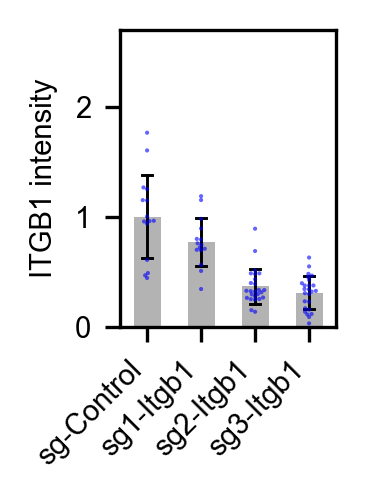

In [94]:
# Swarm plot of 4 categories

outputPrefix = '220608-IF-b1-integrin-d1-bar-swarm'
outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"

fig_width = 1.2
fig_height = 1.8

fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
# ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax = fig.add_axes([0.35, 0.4, 0.6, 0.55])

ax = sns.swarmplot(x='groups', y='b1int_normed', data=df_d1,
                   # hue='sample_id',
#                    palette={'1': 'red', '2': 'green', '3': 'blue', '4': yellow', '5': 'purple'},
                   color="blue",
                   size=1.0, alpha=.6)

ax = sns.barplot(x='groups', y='b1int_normed', data=df_d1,
                 color=".7", alpha=1.0,
                 errwidth=.7, errcolor="k", capsize=.2, ci='sd')

plt.ylim(0, 1.7)
plt.ylim(0, 2.7)
# plt.yticks([0, 3, 6])

plt.xlabel(None)
# plt.ylabel(r"$\beta$1-integrin intensity")
plt.ylabel('ITGB1 intensity')

# make the bar width narrower
change_bar_width(ax, .5)

# rotate x tick labels
# x_labels = ax.get_xticklabels()
x_labels = ['sg-Control', 'sg1-Itgb1', 'sg2-Itgb1', 'sg3-Itgb1']
ax.set_xticklabels(labels=x_labels, rotation=45, ha="right")

# ax.get_legend().remove()

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

if outputFigPath is not None:
    plt.savefig(outputFigPath)


In [69]:
tukeyTest(df_d1.b1int_normed, df_d1.groups)

Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 188_1  401_1   -0.231  0.037  -0.452   -0.01   True
 188_1  402_1  -0.6348  0.001 -0.8324 -0.4372   True
 188_1  403_1  -0.6918  0.001 -0.8895 -0.4942   True
 401_1  402_1  -0.4038  0.001 -0.6014 -0.2061   True
 401_1  403_1  -0.4608  0.001 -0.6584 -0.2632   True
 402_1  403_1   -0.057 0.7944 -0.2282  0.1141  False
----------------------------------------------------
p values of all pair-wise tests:
 [0.03699523 0.001      0.001      0.001      0.001      0.79443296]


In [74]:
for i in df_d1.sgRNA.unique():
    print(i, 'n =', len(df_d1[df_d1.sgRNA==i]))

188 n = 15
401 n = 15
402 n = 25
403 n = 25


In [66]:
df_d2 = df[df.time_d==2]
ctrl_average = df_d2[df_d2.sgRNA=='188'].b1int_peak_height.mean()
df_d2['b1int_normed'] = df_d2['b1int_peak_height'] / ctrl_average

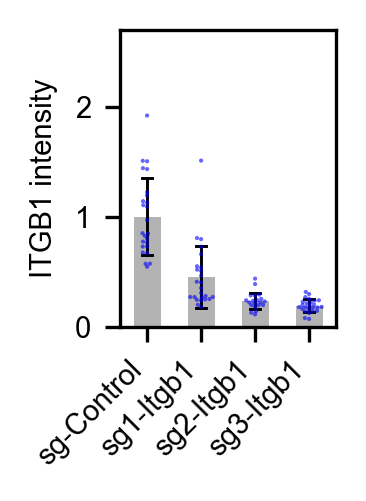

In [92]:
# Swarm plot of 4 categories

outputPrefix = '220608-IF-b1-integrin-d2-bar-swarm'
outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"

fig_width = 1.2
fig_height = 1.8

fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
# ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax = fig.add_axes([0.35, 0.4, 0.6, 0.55])

ax = sns.swarmplot(x='groups', y='b1int_normed', data=df_d2,
                   # hue='sample_id',
#                    palette={'1': 'red', '2': 'green', '3': 'blue', '4': yellow', '5': 'purple'},
                   color="blue",
                   size=1.0, alpha=.6)

ax = sns.barplot(x='groups', y='b1int_normed', data=df_d2,
                 color=".7", alpha=1.0,
                 errwidth=.7, errcolor="k", capsize=.2, ci='sd')

plt.ylim(0, 1.7)
plt.ylim(0, 2.7)
# plt.yticks([0, 3, 6])

plt.xlabel(None)
# plt.ylabel(r"$\beta$1-integrin intensity")
plt.ylabel('ITGB1 intensity')

# make the bar width narrower
change_bar_width(ax, .5)

# rotate x tick labels
# x_labels = ax.get_xticklabels()
x_labels = ['sg-Control', 'sg1-Itgb1', 'sg2-Itgb1', 'sg3-Itgb1']
ax.set_xticklabels(labels=x_labels, rotation=45, ha="right")

# ax.get_legend().remove()

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

if outputFigPath is not None:
    plt.savefig(outputFigPath)


In [71]:
tukeyTest(df_d2.b1int_normed, df_d2.groups)

Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 188_2  401_2  -0.5498  0.001 -0.7277 -0.3718   True
 188_2  402_2   -0.766  0.001 -0.9548 -0.5772   True
 188_2  403_2  -0.8095  0.001 -0.9875 -0.6315   True
 401_2  402_2  -0.2162 0.0181  -0.405 -0.0275   True
 401_2  403_2  -0.2597 0.0014 -0.4377 -0.0817   True
 402_2  403_2  -0.0435    0.9 -0.2323  0.1453  False
----------------------------------------------------
p values of all pair-wise tests:
 [0.001      0.001      0.001      0.01809277 0.00137611 0.9       ]


In [73]:
for i in df_d2.sgRNA.unique():
    print(i, 'n =', len(df_d2[df_d2.sgRNA==i]))

188 n = 25
401 n = 25
402 n = 20
403 n = 25


In [75]:
df_d4 = df[df.time_d==4]
ctrl_average = df_d4[df_d4.sgRNA=='188'].b1int_peak_height.mean()
df_d4['b1int_normed'] = df_d4['b1int_peak_height'] / ctrl_average

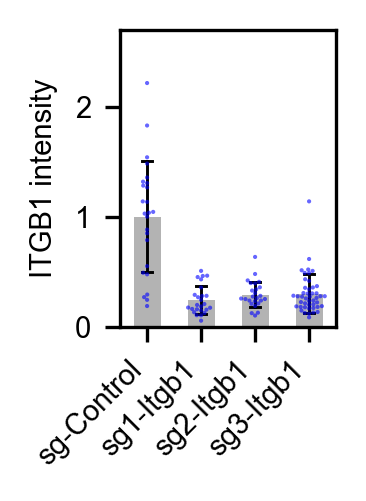

In [89]:
# Swarm plot of 4 categories

outputPrefix = '220608-IF-b1-integrin-d4-bar-swarm'
outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"

fig_width = 1.2
fig_height = 1.8

fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
# ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax = fig.add_axes([0.35, 0.4, 0.6, 0.55])

ax = sns.swarmplot(x='groups', y='b1int_normed', data=df_d4,
                   # hue='sample_id',
#                    palette={'1': 'red', '2': 'green', '3': 'blue', '4': yellow', '5': 'purple'},
                   color="blue",
                   size=1.0, alpha=.6)

ax = sns.barplot(x='groups', y='b1int_normed', data=df_d4,
                 color=".7", alpha=1.0,
                 errwidth=.7, errcolor="k", capsize=.2, ci='sd')

plt.ylim(0, 1.7)
plt.ylim(0, 2.7)
# plt.yticks([0, 3, 6])

plt.xlabel(None)
# plt.ylabel(r"$\beta$1-integrin intensity")
plt.ylabel('ITGB1 intensity')

# make the bar width narrower
change_bar_width(ax, .5)

# rotate x tick labels
# x_labels = ax.get_xticklabels()
x_labels = ['sg-Control', 'sg1-Itgb1', 'sg2-Itgb1', 'sg3-Itgb1']
ax.set_xticklabels(labels=x_labels, rotation=45, ha="right")

# ax.get_legend().remove()

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

if outputFigPath is not None:
    plt.savefig(outputFigPath)


In [77]:
tukeyTest(df_d4.b1int_normed, df_d4.groups)

Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 188_4  401_4   -0.756  0.001  -0.955  -0.557   True
 188_4  402_4  -0.7082  0.001 -0.9071 -0.5092   True
 188_4  403_4  -0.7016  0.001 -0.8771 -0.5262   True
 401_4  402_4   0.0479    0.9 -0.1511  0.2468  False
 401_4  403_4   0.0544 0.8321 -0.1211  0.2298  False
 402_4  403_4   0.0065    0.9 -0.1689   0.182  False
----------------------------------------------------
p values of all pair-wise tests:
 [0.001     0.001     0.001     0.9       0.8321047 0.9      ]


In [78]:
for i in df_d4.sgRNA.unique():
    print(i, 'n =', len(df_d4[df_d4.sgRNA==i]))

188 n = 25
401 n = 25
402 n = 25
403 n = 45


In [79]:
df_d7 = df[df.time_d==7]
ctrl_average = df_d7[df_d7.sgRNA=='188'].b1int_peak_height.mean()
df_d7['b1int_normed'] = df_d7['b1int_peak_height'] / ctrl_average

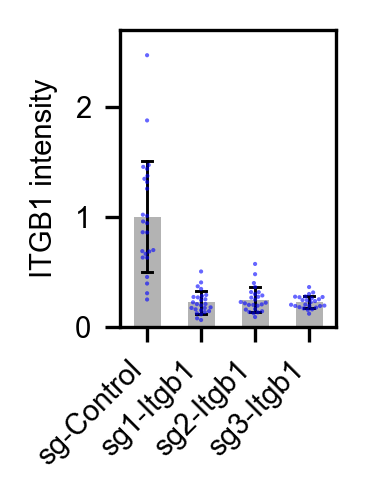

In [87]:
# Swarm plot of 4 categories

outputPrefix = '220608-IF-b1-integrin-d7-bar-swarm'
outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"

fig_width = 1.2
fig_height = 1.8

fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
# ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax = fig.add_axes([0.35, 0.4, 0.6, 0.55])

ax = sns.swarmplot(x='groups', y='b1int_normed', data=df_d7,
                   # hue='sample_id',
                   color="blue",
                   size=1.0, alpha=.6)

ax = sns.barplot(x='groups', y='b1int_normed', data=df_d7,
                 color=".7", alpha=1.0,
                 errwidth=.7, errcolor="k", capsize=.2, ci='sd')

# plt.ylim(0, 1.7)
plt.ylim(0, 2.7)
# plt.yticks([0, 3, 6])

plt.xlabel(None)
# plt.ylabel(r"$\beta$1-integrin intensity")
plt.ylabel('ITGB1 intensity')

# make the bar width narrower
change_bar_width(ax, .5)

# rotate x tick labels
# x_labels = ax.get_xticklabels()
x_labels = ['sg-Control', 'sg1-Itgb1', 'sg2-Itgb1', 'sg3-Itgb1']
ax.set_xticklabels(labels=x_labels, rotation=45, ha="right")

# ax.get_legend().remove()

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

if outputFigPath is not None:
    plt.savefig(outputFigPath)


In [95]:
tukeyTest(df_d7.b1int_normed, df_d7.groups)

Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
 188_7  401_7    -0.78 0.001 -0.9805 -0.5795   True
 188_7  402_7  -0.7534 0.001 -0.9539 -0.5529   True
 188_7  403_7  -0.7761 0.001 -0.9766 -0.5756   True
 401_7  402_7   0.0266   0.9 -0.1739  0.2271  False
 401_7  403_7   0.0039   0.9 -0.1966  0.2044  False
 402_7  403_7  -0.0227   0.9 -0.2232  0.1778  False
---------------------------------------------------
p values of all pair-wise tests:
 [0.001 0.001 0.001 0.9   0.9   0.9  ]


In [81]:
for i in df_d7.sgRNA.unique():
    print(i, 'n =', len(df_d7[df_d7.sgRNA==i]))

188 n = 25
401 n = 25
402 n = 25
403 n = 25
